## 1. Data

### Data Preprocessing

In [1]:
import pandas as pd
import networkx as nx
import string
import numpy as np
import scipy
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt
import random

Loading the datasets:

In [2]:
edges = pd.read_csv('edges.csv')

In [3]:
hero_network = pd.read_csv('hero-network.csv')

In [4]:
nodes = pd.read_csv('nodes.csv')

Removing inconsistencies:

In [5]:
#Removing extra spaces at the end of the hero name
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())

In [6]:
#Replace 'SPIDER-MAN/PETER PAR' with 'SPIDER-MAN/PETER PARKER'
hero_network.replace({'SPIDER-MAN/PETER PAR': 'SPIDER-MAN/PETER PARKER'}, inplace = True)

In [7]:
#Removing extra '/'
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip('/'))
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip('/'))
edges['hero'] = edges['hero'].apply(lambda x: x.strip('/'))

In [8]:
#After this we need to remove again the empty spaces at the end
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())
edges['hero'] = edges['hero'].apply(lambda x: x.rstrip())

In [9]:
#Removing a typo we found in the dataset 'nodes'
nodes.replace({'SPIDER-MAN/PETER PARKERKER': 'SPIDER-MAN/PETER PARKER'}, inplace = True)

Removing duplicates:

Let's remove rows where hero1 is equal to hero2 first.

In [10]:
# removing rows where hero1 is equal to hero2 
hero_network.drop((hero_network[hero_network['hero1'] == hero_network['hero2']]).index, inplace = True)

In [11]:
# sorting hero names by rows to avoid mistakes while computing the number of collaborations and the weights of the first graph
hero_network = hero_network.apply(lambda row: sorted(row), axis=1, result_type='expand').set_axis(hero_network.columns, axis=1)


### Graphs setup

##### First graph

In [12]:
# computing the number of collaborations (size) between two heroes 
hero_network = hero_network.groupby(['hero1', 'hero2']).size().reset_index().rename(columns={0: 'size'})

In [13]:
hero_network

,hero1,hero2,size
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,G'RATH,1
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1
...,...,...,...
167095,ZEFRA,ZON,1
167096,ZEUS,ZIRAN,1
167097,ZEUS,ZURAS,4
167098,ZIRAN,ZON,1


In [14]:
# initializing the first graph
G_hero_net = nx.Graph()

We want the graph to be weighted and we also want the weights to be lower for heroes with more collaborations, hence we take as weights the reciprocal of the number of collaboration (the size)

In [15]:
# creating a list of 3d tuples where the first two elements are the nodes and the last is the weight
edges_l = []
hero_network.apply(lambda row : edges_l.append((row['hero1'], row['hero2'], 1/row['size'])), axis = 1)

# creating the weighted graph
G_hero_net.add_weighted_edges_from(edges_l)


In [16]:
nx.info(G_hero_net)

C:\Users\erica\AppData\Local\Temp\ipykernel_12484\1638737127.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero_net)


'Graph with 6421 nodes and 167100 edges'

##### Second graph

In [17]:
# initializing the second graph
G_comic_net = nx.Graph()

In [18]:
# adding the nodes first
G_comic_net.add_nodes_from(list(nodes['node']))

# creating the edges
edges_list= []
edges.apply(lambda row: edges_list.append((row['hero'], row['comic'])), axis = 1)

#adding the edges to the graph
G_comic_net.add_edges_from(edges_list)

In [19]:
# creating two lists, one containing only the heroes and the other containing only the comics
n_h=nodes[nodes['type'] == 'hero']['node'].tolist()
n_c=nodes[nodes['type'] == 'comic']['node'].tolist()

# merging the two lists into a dictionary
dict_heroes_comics = {key: 'hero' if key in n_h else 'comic' for key in n_c + n_h}

# setting the type as attributes of the nodes
nx.set_node_attributes(G_comic_net, dict_heroes_comics, 'type')

In [20]:
nx.info(G_comic_net)

C:\Users\erica\AppData\Local\Temp\ipykernel_12484\3041480722.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_comic_net)


'Graph with 19518 nodes and 96104 edges'

# Backend Implementation & Frontend Implementation

Let's define the functions (functionality + visualization) we are going to use to build the controller system.

## Functionality 1 - extract the graph's features

In [21]:
all_heroes=len(edges['hero'].value_counts())
all_heroes

6439

we save that value because it will be used in the functions to create the subgraph

In [22]:
def create_subN1(G,N):
    if N == all_heroes: # if N is not set by the user, the function should consider the whole data
        sub_g=G
    else: # otherwise we select only the top n nodes 
        series=edges['hero'].value_counts()[0:N]
        names_list=series.index.tolist()
        sub_g=G.subgraph(names_list)
    return sub_g

The difference between subN1 and subN2 is that in the latter one we consider also all the comic nodes, otherwise the graph will be empty (the edges are only  between a hero and a comic)

In [23]:
def create_subN2(G,N):
    if N == all_heroes: # if N is not set by the user, the function should consider the whole data
        sub_g=G
    else: # otherwise we select only the top n nodes of heroes + all comics
        series=edges['hero'].value_counts()[0:N]
        names_list=series.index.tolist()
        comics_list=edges['comic'].value_counts().index.tolist()
        all=names_list+comics_list
        sub_g=G.subgraph(all)
    return sub_g

In [24]:
def functional1_type1(sub_g, G_type):
    output={} # initialize the dict of outputs

    # The number of nodes in the network
    num_nodes = sub_g.number_of_nodes()
    output['Number of nodes']=num_nodes

    # The number of collaborations of each superhero with the others (i.e the degrees)
    degrees=dict(sub_g.degree())
    output['Collaborations']=list(degrees.items())

    # The network's density
    density = nx.density(sub_g)
    output['Density']=density

    # The average degree of the network
    avg_degree=sum(degrees.values())/len(degrees.values()) # compute the average
    output['Average Degree']=avg_degree

    # The network's degree distribution
    degrees_list=list(degrees.values())
    degree_distribution = Counter(degrees_list) # Given the degrees list we obatin the frequency distribution
    sorted_degree_distribution = sorted(degree_distribution.items(), key=lambda x: x[0]) # we sort the frequency by the keys
    output['Degree Distribution']=sorted_degree_distribution # The output means how many times each degree appears

    # The network's Hubs
    sorted_dict = sorted(degrees.items(), key=lambda x: x[1]) # sort the degrees
    pos=int(len(sorted_dict)*0.95) # find the rigth position (We want the nodes that have degree greater than 95% of the other)
    output['Network Hubs']=sorted_dict[pos-1::] # create the output

    # Whether the Network is sparse or dense
    if density>0.5:
        output['Dense']=1.0 # 1 if it is dense
    else:
        output['Dense']=0.0 # 0 if it is sparse

    return output 


In [25]:

def functional1_type2(sub_g, G_type):

    output={} # initialize the dict of outputs

    # The following 3 rows of code will be usefull for the functionals regarding only the comic nodes

    # we obtain for each node the type
    dictionary_types=dict(nx.get_node_attributes(sub_g, "type"))
    # Then we obtain the list with only the comic nodes
    keys_comic = {k: v for k, v in dictionary_types.items() if v == 'comic'}
    comics=list(keys_comic.keys())

    # Now we can start:

    # regarding the Density of the graph we will use both types of nodes

    # The network's density
    density = nx.density(sub_g)
    output['Density']=density

    # Whether the Network is sparse or dense
    if density>0.5:
        output['Dense']=1.0 # 1 if it is dense
    else:
        output['Dense']=0.0 # 0 if it is sparse

    # regarding the other operations we will consider only the comic type:

    # The number of nodes for both types
    total_number= sub_g.number_of_nodes()

    degrees=dict(sub_g.degree()) # create the separate subset regarding the node type
    comics_subset = {k: v for k, v in degrees.items() if k in comics}
    heroes_subset = {k: v for k, v in degrees.items() if k not in comics} 

    output['Total number of nodes']=total_number

    output['Number of heroes']=len(list(heroes_subset.items()))

    output['Number of comics']=len(list(comics_subset.items()))

    # The number of heroes that have appeared in each comic (i.e the degrees)
    degrees_subset = {k: v for k, v in degrees.items() if k in comics} # exctract the degrees
    output['Number of heroes in the comic']=list(degrees_subset.items())

    # The network's degree distribution
    degrees_list=list(degrees_subset.values())
    degree_distribution = Counter(degrees_list) # Given the degrees list we obatin the frequency distribution
    sorted_degree_distribution = sorted(degree_distribution.items(), key=lambda x: x[0]) # we sort the frequency by the keys
    output['Degree Distribution']=sorted_degree_distribution # The output means how many times each degree appears

    # The average degree of the network
    avg_degree=sum(degrees_subset.values())/len(degrees_subset.values()) # compute the average
    output['Average Degree']=avg_degree

    # The network's Hubs
    sorted_dict = sorted(degrees_subset.items(), key=lambda x: x[1]) # sort the degrees
    pos=int(len(sorted_dict)*0.95) # find the rigth position (We want the nodes that have degree greater than 95% of the other)
    output['Network Hubs']=sorted_dict[pos-1::] # create the output

    return output



In [26]:
def functionality1(G, G_type, N = all_heroes):
    #################### Neither 1 or 2 ########################################

    if G_type not in [1, 2]: 
        raise ValueError('Invalid graph type: remember, this function only accepts graph types equal to 1 or 2')

    #################### TYPE = 1 ##############################################
    elif G_type == 1:
        # Create the Sub 
        sub_g= create_subN1(G,N)
        # Apply all the functions for Type = 1
        output= functional1_type1(sub_g, G_type)


    #################### TYPE = 2 ##############################################

    else: 
        # Create the Sub  
        sub_g= create_subN2(G,N)
        # Apply all the functions for Type = 2
        output= functional1_type2(sub_g, G_type)


    return output

## Visualization 1 - Visualize some features of the network

In [27]:
def visualization1(G, G_type, N):
  example1=functionality1(G, G_type, N) # call the function

  ############### A table containing the following general information about the graph: ##############
  # we append all the information in the 'values' list
  values=[]
  if G_type == 1: # since the names are different in the output of functionality 1 we differenciate the precedure
    values.append(example1['Number of nodes'])
  else:
    values.append(example1['Total number of nodes'])

  values.append(example1['Density'])
  values.append(example1['Average Degree'])
  values.append(example1['Dense'])
  # Then, we create the table
  table = tabulate([values], headers=["Number of nodes", "Density", "Average degree", "Dense"], tablefmt="fancy_grid")
  print('General information about the graph:')
  print(table)


  ############ A table that lists the network's hubs #######################
  example1['Network Hubs'].sort(key=lambda x: x[1], reverse=True) # We take the hubs from the results of function 1
  table_hub = tabulate(example1['Network Hubs'], headers=["Node", "Degree"], tablefmt="fancy_grid") # we put them into a table
  print("Network's hubs:")
  print(table_hub)
  print(' ')


  ############## A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)  ###############
  if G_type == 1:
    example1['Collaborations'].sort(key=lambda x: x[1], reverse=True) # sort the collaborations in descending order
    ex=dict(example1['Collaborations']) # create a dictionary
    names = list(ex.keys()) # extract the keys
    values = list(ex.values()) # extract the names

    # plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color='cadetblue', edgecolor='k', linewidth=2)
    plt.title('Histogram of the number of collaborations of each hero')
    plt.xlabel('Hero')
    plt.ylabel('Collaborations')
    plt.xticks(rotation=90)
    plt.show()
    print('')


  ############## A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)  ###############
  if G_type == 2:
    example1['Number of heroes in the comic'].sort(key=lambda x: x[1], reverse=True) # sort the Number of heroes in the comic in descending order
    ex=dict(example1['Number of heroes in the comic']) # create a dictionary
    names = list(ex.keys()) # extract the keys
    values = list(ex.values()) # extract the names

    # plot the histogram 
    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color='cadetblue', edgecolor='k', linewidth=2)
    plt.title('Histogram of the number of collaborations of each hero')
    plt.xlabel('Hero')
    plt.ylabel('Collaborations')
    plt.xticks(rotation=90)
    plt.show()
    print('')    


  ########## A plot depicting the degree distribution of the network ##################

  adict=dict(example1['Degree Distribution']) # create a dictionary from the results of the degree distribution feature in function 1
  val=list(adict.values()) # extract the keys
  keys=list(adict.keys()) # extract the names

  plt.bar(range(len(val)), val, color='tomato',  edgecolor='k', linewidth=2)
  plt.title('Histogram of the degree distribution')
  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  plt.xticks(range(len(keys)),keys)
  plt.show()

## Functionality 2 - Find top superheroes!


In [28]:
def functionality2(G, node, metric, N):
     # finding the topN
     topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
     topN = topN.reset_index()

     if G == G_hero_net:
          # creating the subgraph
          subG = G.subgraph(list(topN['hero']))

          # computing the metrics on the whole subgraph
          if metric == 'Betweenness Centrality':
               all_values = nx.betweenness_centrality(subG, weight = 'weight')

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG, weight = 'weight')

          elif metric == 'Closeness Centrality':
               all_values = nx.closeness_centrality(subG, distance = 'weight')

          elif metric == 'Degree Centrality':
               all_values = nx.degree_centrality(subG)

          # computing the metrics only on the node of interest 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     if G == G_comic_net:
          # creating the subgraph taking from the graph G_comic_net all the edges linked to heroes in top N
          reduced_edges = []
          for n in topN['hero']:
               for elem in G.edges(n):
                    reduced_edges.append(elem)
          subG = nx.Graph()
          subG.add_edges_from(set(reduced_edges))
          
          # computing the metrics on the whole subgraph
          if metric == 'Betweenness Centrality':
               all_values = nx.betweenness_centrality(subG)

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG)

          elif metric == 'Closeness Centrality':
               all_values = nx.closeness_centrality(subG)

          elif metric == 'Degree Centrality':
               all_values = nx.degree_centrality(subG)

          # computing the metrics only on the node of interest 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     

## Visualization 2 - Visualize centrality measure

In [29]:
def visualization2(G, node, N):
    
    # building a table to show different scores
    col_names = ["Betweenness Centrality", "PageRank", "Closeness Centrality", "Degree centrality"]

    all_values, n_value = functionality2(G, node, 'Betweenness Centrality', N)
    data = [["Average value", np.mean(list(all_values.values()))], ["Node value", n_value]]

    all_values, n_value = functionality2(G, node, 'PageRank', N)
    data[0].append(np.mean(list(all_values.values())))
    data[1].append(n_value)

    all_values, n_value = functionality2(G, node, 'Closeness Centrality', N)
    data[0].append(np.mean(list(all_values.values())))
    data[1].append(n_value)

    all_values, n_value = functionality2(G, node, 'Degree Centrality', N)
    data[0].append(np.mean(list(all_values.values())))
    data[1].append(n_value)

    print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

## Functionality 3

In [30]:
def functionality3(G, h, h1, hn, N):

    #first create subgraph

    topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
    topN = topN.reset_index()

    reduced_edges = []
    for n in topN['hero']:
        for elem in G.edges(n):
            reduced_edges.append(elem)
    subG = nx.Graph()
    subG.add_edges_from(set(reduced_edges))
    
    nx.set_node_attributes(subG, dict_heroes_comics, 'type')
    
    #then compute all possible paths from initial node to final node

    all_paths = list(nx.all_simple_paths(subG, source = h1, target = hn))    #this is a list of lists, each one of them is a possible path prom h1 to hn, with all the nodes that need to be crossed.

    #then check which ones of the possible paths cross the requested nodes in the correct order; first exclude those who don't include the required nodes

    good_paths = []
    a = set(h)
    for path in all_paths: 
        b = set(path)
        check = a.issubset(b)
        if check:
            good_paths.append(path)


    if len(good_paths) == 0:
        print('There is no such path.')
    
    #then on those paths, check if the order is correct

    better_paths = []

    for path in good_paths:

        unvisited_heroes = h.copy()
        for elem in path:
            if elem == unvisited_heroes[0]:
                unvisited_heroes.pop(0)
                if len(unvisited_heroes) == 0:
                    better_paths.append(path)
                    break

    #finally select the shortest among these paths and return it 


    best_path = min(better_paths, key= len)         #If there are more paths with minimum length, this function returns only the first path encountered. 

    return best_path


## Visualization 3

In [31]:
def visualization3(G, h, h1, hn, N):

    best = functionality3(G, h, h1, hn, N)   #apply corresponding functionality to find the shortest ordered route and assign it to 'best'

    G = nx.Graph(name = 'route')  #create an empty graph
    
    route = best.copy()    #copy best into route
    route_edges = [(route[n], route[n+1]) for n in range(len(route)-1)]    #compute edges
    G.add_nodes_from(route)    #add nodes to the new graph
    G.add_edges_from(route_edges)  #add edges to the new graph
    
    #now plot the graph
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos=pos)
    nx.draw_networkx_labels(G,pos=pos)

    edge_num = {edge: i+1 for i,edge in enumerate(route_edges)}
    nx.draw_networkx_edges(G, pos=pos, edgelist=route_edges, edge_color='red')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_num, font_color = 'black')

    plt.show()
 

## Functionality 4 - Disconnecting Graphs

For this functionality we took a cue from the Ford-Fulkerson algorithm 


In [32]:
def DepthFirstSearch(G, node, visited):
    '''Depth First Search function'''
    visited[node] = 1
    for neighbor in G.neighbors(node):
        if visited[neighbor] == 0:
            DepthFirstSearch(G, neighbor, visited)
    return 



def functionality4(G, heroA, heroB, N):
    # finding top N heroes
    topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(10)
    topN = topN.reset_index()
    
    # creating the subgraph
    if G == G_hero_net:
        subG = G.subgraph(list(topN['hero']))
    elif G == G_comic_net:
        # in this case we create the subgraph taking from the graph G_comic_net all the edges linked to heroes in topN
        reduced_edges = []
        for n in topN['hero']:
            for elem in G.edges(n):
                reduced_edges.append(elem)
        subG = nx.Graph()
        subG.add_edges_from(set(reduced_edges))

    # dictionary to mark if a node has been visited during the depth first search
    visited = {node: 0 for node in subG.nodes}
    
    # depth first serach starting from the node heroA
    DepthFirstSearch(subG, heroA, visited)

    # initialing a counter for the minimum number of cuts
    counter = 0
    # here will be saved if I already counted that edge as one to cut
    marked = []

    # if heroA e heroB are directly linked, it marks the edge between them as one to cut and it increases the counter
    if heroB in subG.neighbors(heroA):
        marked.append((heroA, heroB))
        counter += 1

    # loop over all the nodes of the subgraph 
    for node in subG.nodes:
        if node == heroB:
            continue 

        #if the node has not been visited it means that it's not linked to heroA and it can be skipped
        if visited[node] == 0:
            continue
        
        # in any other case I loop over the neighbors of the node
        for n in subG.neighbors(node):
            # if a neighbor of the node is also a neighbor of heroB
            if n in subG.neighbors(heroB) and n!=heroB:
                # if we didn't pass through that edge yet
                if ((n, heroB) not in marked):
                    # mark the edge as one to cut and increase the counter
                    marked.append((n, heroB))
                    counter += 1
    
    return counter, marked, subG

## Visualization 4 - Visualize the disconnected graph

In [33]:
def visualization4(G, heroA, heroB, N):
    min_num, min_edges, subG = functionality4(G, heroA, heroB, N)

    print('The minimum number of links that should be disconnected is', min_num)
    
    # plotting the orginal graph
    plt.clf()
    plt.figure(figsize=(15, 10))
    nx.draw(subG, edge_color = 'grey', node_color = 'green', with_labels = True)
    plt.title('Original graph')
    plt.show()

    # plotting the graph after removing the links and identifying the two nodes
    reduced_subG = nx.Graph(subG)
    reduced_subG.remove_edges_from(list(min_edges))
    plt.clf()
    plt.figure(figsize=(15, 10))
    color_map = ['purple' if (node == heroA or node == heroB) else 'green' for node in subG]        
    nx.draw(reduced_subG, node_color = color_map, edge_color = 'grey', with_labels = True)
    plt.title('Subgraphs G_A and G_B')
    plt.show()

##  Functionality 5 - Extracting Communities

In [34]:
def functionality5(G, N, hero1, hero2):
    # since we can use only the type 1 graph, we used the function 'create_subN1' defined before in functionality 1
    sub_graph= create_subN1(G,N)
    output={} # initialize the dict of outputs

    # we use min_num for saving the minimum number of cuts
    min_num = 0
    
    subG = nx.Graph(sub_graph)

    # while our graph is connected
    while nx.is_connected(subG):

        # we compute the edge betweenness centrality that returns a dictionary
        ebg = nx.edge_betweenness_centrality(subG)
        
        # we sort the dictioanry ebg to spot the maximum of the values 
        ebg = sorted(ebg.items(), key = lambda item: item[1], reverse = True)

        # update min_num
        min_num += 1

        edge = ebg[0][0]
        
        # we remove the edges with the higher value
        subG.remove_edge(edge[0],edge[1])
    
    communities = [] # initialize the list of communities
    together = False # we start with False as initialization value
    
    for community in nx.connected_components(subG):
        # we append to communities the list
        communities.append(list(community))
        # only if hero1 and hero2 are in the same community we set together = True
        if (hero1 in community) and (hero2 in community):
            together = True
    
    # we store all the requested values in our dictionary
    output['Minimum number of edges']= min_num
    output['hero1 and hero2 together']= together
    output['list of communities']= communities
    
    return output, sub_graph, subG

## Visualization 5 - Visualize the communities

In [35]:
def searchCommunity(d,value):
      # given a dictionary ( in the form of a list of lists) and a value that function will output the key  
      for key, values in d.items():
            for v in values:
                  if v == value:
                        community_found = key
                        break
      return community_found
            

In [36]:
def visualization5(G, N, hero1, hero2):
  
  # First, we call the function
  results, sub_graph, subG =functionality5(G, N, hero1, hero2)


  ################ Print the number of links that should be removed to have the communities ##############################

  # we use only the first results of our function
  print(f"The minimum number of edges that should be removed to form communities is", results['Minimum number of edges'])
  print('\n')

  #################### A table depicting the communities and the heroes that belong to each community ####################

  communities=len(results['list of communities']) # get the number of communities
  print(f"There are", communities,"communities in the network:")
  
  # we want a list of lists in which there are the identifiers of community and the nodes that belong to it:

  elements=[] # initialize the list
  for i in range(0,communities):
    string_ = str('Community ')+str(i) # create the string with the name of the community
    print(string)
    print(results['list of communities'][i])
    print('\n')
    # extract the community from the results of our function5
    elements.append([string_, results['list of communities'][i]]) # create the list of lists



  #################### Plot the original graph ####################


  print('The Original graph:')
  print(' ')

  plt.figure(figsize=(15, 10))
  plt.clf()
  plt.title('Original graph')
  pos= nx.spring_layout(sub_graph) # we use the spring_layout to better represent our graph
  nx.draw(sub_graph,pos, edge_color = 'moccasin', node_color = 'royalblue', with_labels = True, font_size=7)

  plt.show()
  print(' ')

  #################### Plot the graph showing the communities in the network ####################
  node_color = {node: '' for node in subG.nodes}
  colors = set()
  for community in results['list of communities']:
    color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    if color in colors:
      color = "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
    colors.add(color)
    for elem in community:
      node_color[elem] = color
  
  plt.clf()
  plt.figure(figsize=(15, 10))
  nx.draw(subG, node_color = node_color.values(), edge_color = 'grey', with_labels = True)
  plt.title('Graph showing the communities in the network')
  plt.show()

  #################### Plot the final graph and identify the community/communities of Hero_1 and Hero_2 ####################
  print('The Final graph:')
  print(' ')
  plt.figure(figsize=(15, 10))
  plt.clf()
  plt.title('Final graph')
  color_map = ['tomato' if (node == hero1 or node == hero2) else 'green' for node in subG]
  pos= nx.spring_layout(subG) # we use the spring_layout to better represent our graph
  nx.draw(subG,pos, edge_color = 'moccasin', node_color = color_map , with_labels = True, font_size=7)

  plt.show()
  print(' ')

  e=dict(elements) # create a dict form the previous list of lists 'elements'

  if results['hero1 and hero2 together'] == True:

    #search the community
    community_found = searchCommunity(e,hero1)

    print(f"The heroes", hero1, " and ", hero2,"are in the same community: ", community_found)

  else:
    # find the communities for both 
    community_found1 = searchCommunity(e,hero1)
    community_found2 = searchCommunity(e,hero2)

    print(f"The heroes", hero1, " and ", hero2,"are not in the same community: ")
    print( hero1," is in ",community_found1 ," and ", hero2," is in ",community_found2)




# Implementing controller system

Now we are goint to build the controller system using all the previous functions. The user is asked to choose the visualization and to insert the parameters of the funcionalities.

In [37]:
def controller ():

    print('Choose a visualization:')
    print('1. Visualize some features of the network \n 2. Visualize centrality measure \n 3. Visualize the shortest ordered route \n 4. Visualize disconnected graph \n 5. Visualize the communities')
    choice = int(input())
    print(choice)
  
    if choice == 1:
        print('Choose a graph: \n 1. First graph (G_hero_net) \n 2. Second graph (G_comic_net)')
        G_type = int(input())
        print(G_type)
        

        if G_type == 1:
            G = G_hero_net
        elif G_type == 2:
            G = G_comic_net
        
        print('Choose the number N of top heroes to consider. Write ALL if you want to pick all of them.')
        N = input()
        print(N)
        
        if N == 'ALL':
            N = len(G.nodes)
        else:
            N = int(N)
        
        print('----------------------------------------------------------------------------------------------------- \n')
        visualization1(G, G_type, N)
            
    if choice == 2:
        print('Choose a graph: \n 1. First graph (G_hero_net) \n 2. Second graph (G_comic_net)')
        G_type = int(input())
        print(G_type)
        

        if G_type == 1:
            G = G_hero_net

        elif G_type == 2:
            G = G_comic_net
            
        print('Choose the number N of top heroes to consider. Write ALL if you want to pick all of them. ')
        N = input()
        print(N)
      
        if N == 'ALL':
            N = len(G.nodes)
        else:
            N = int(N)

        print('Choose a node (a hero): ')
        node = input()
        print(node)

        print('----------------------------------------------------------------------------------------------------- \n')
        visualization2(G, node, N)

    if choice == 3:
        G = G_comic_net
        print('Choose the number N of top heroes to consider: ')
        N = int(input())
        print(N)
        
        print('Choose a sequence of superheroes, divided by commas:')
        h = input().split(', ')
        print(h)
        
        print('Insert the starting node: \n')
        h1 = input()
        print(h1)
        
        print('Insert the ending node: \n')
        hn = input()
        print(hn)
        

        print('----------------------------------------------------------------------------------------------------- \n')
        visualization3(G, h, h1, hn, N)

    if choice == 4:
        print('Choose a graph: \n 1. First graph (G_hero_net) \n 2. Second graph (G_comic_net)')
        G_type = int(input())
        print(G_type)
        

        if G_type == 1:
            G = G_hero_net
        elif G_type == 2:
            G = G_comic_net
            
        print('Choose the number N of top heroes to consider. Write ALL if you want to pick all of them.')
        N = input()
        print(N)
        
        if N == 'ALL':
            N = len(G.nodes)
        else:
            N = int(N)
        
        print('Choose heroA: ')
        heroA = input()
        print(heroA)
        
        print('Choose heroB: ')
        heroB = input()
        print(heroB)
        
        
        print('----------------------------------------------------------------------------------------------------- \n')
        visualization4(G, heroA, heroB, N)

    if choice == 5:
        G = G_hero_net
        print('Choose the number N of top heroes to consider. Write ALL if you want to pick all of them.')
        N = input()
        print(N)
        
        if N == 'ALL':
            N = len(G.nodes)
        else:
            N = int(N)
        
        print('Choose hero1: ')
        hero1 = input()
        print(hero1)

        print('Choose hero2: ')
        hero2 = input()
        print(hero2)
        
        print('----------------------------------------------------------------------------------------------------- \n')
        visualization5(G, N, hero1, hero2)
        


Let's have some tests!

##### Tests on functionality1

Choose a visualization:

 1. Visualize some features of the network 
 2. Visualize centrality measure 
 3. Visualize the shortest ordered route 
 4. Visualize disconnected graph 
 5. Visualize the communities
1


Choose a graph: 
 1. First graph (G_hero_net) 
 2. Second graph (G_comic_net)
1


Choose the number N of top heroes to consider. Write ALL if you want to pick all of them.
50


----------------------------------------------------------------------------------------------------- 

General information about the graph:
╒═══════════════════╤═══════════╤══════════════════╤═════════╕
│   Number of nodes │   Density │   Average degree │   Dense │
╞═══════════════════╪═══════════╪══════════════════╪═════════╡
│                50 │  0.974694 │            47.76 │       1 │
╘═══════════════════╧═══════════╧══════════════════╧═════════╛
Network's hubs:
╒══════════════════════╤══════════╕
│ Node                 │   Degree │
╞══════════════════════╪══════════╡
│ HULK/DR. ROBERT BRUC │      

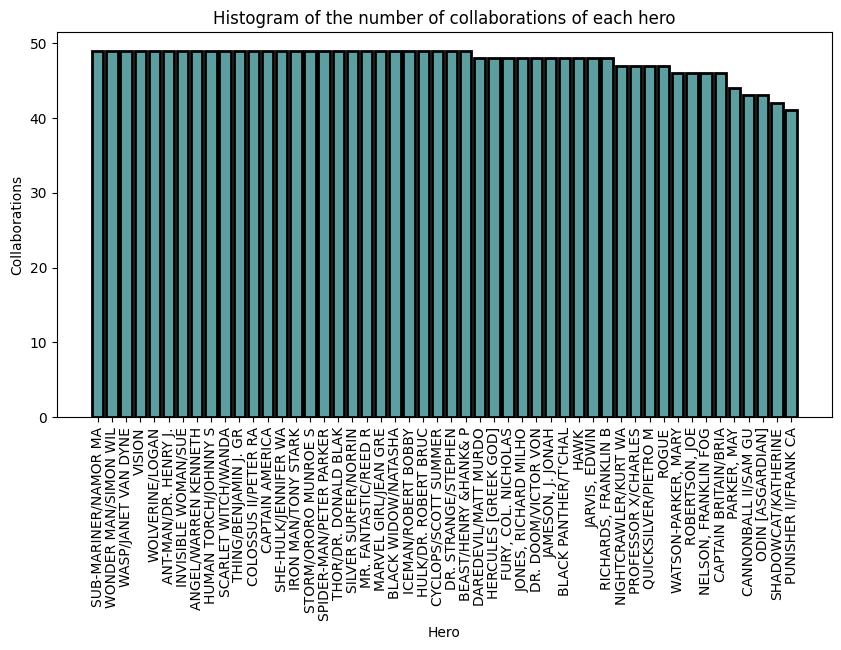

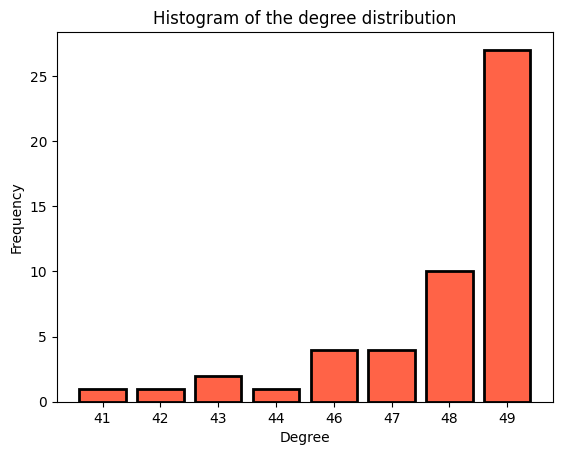

In [38]:
controller()

##### Tests on functionality2


In [43]:
controller()

Choose a visualization:

 1. Visualize some features of the network 
 2. Visualize centrality measure 
 3. Visualize the shortest ordered route 
 4. Visualize disconnected graph 
 5. Visualize the communities
2


Choose a graph: 
 1. First graph (G_hero_net) 
 2. Second graph (G_comic_net)
1


Choose the number N of top heroes to consider. Write ALL if you want to pick all of them. 
10


Choose a node (a hero): 
CAPTAIN AMERICA


----------------------------------------------------------------------------------------------------- 

╒═══════════════╤══════════════════════════╤════════════╤════════════════════════╤═════════════════════╕
│               │   Betweenness Centrality │   PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪══════════════════════════╪════════════╪════════════════════════╪═════════════════════╡
│ Average value │                0.0361111 │  0.1       │                126.784 │                   1 │
├───────────────┼─────────────────────────

In [42]:
controller()

Choose a visualization:

 1. Visualize some features of the network 
 2. Visualize centrality measure 
 3. Visualize the shortest ordered route 
 4. Visualize disconnected graph 
 5. Visualize the communities
2


Choose a graph: 
 1. First graph (G_hero_net) 
 2. Second graph (G_comic_net)
2


Choose the number N of top heroes to consider. Write ALL if you want to pick all of them. 
10


Choose a node (a hero): 
CAPTAIN AMERICA


----------------------------------------------------------------------------------------------------- 

╒═══════════════╤══════════════════════════╤═════════════╤════════════════════════╤═════════════════════╕
│               │   Betweenness Centrality │    PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪══════════════════════════╪═════════════╪════════════════════════╪═════════════════════╡
│ Average value │              0.000416292 │ 0.000165044 │               0.2856   │         0.000552289 │
├───────────────┼─────────────────────

##### Tests on functionality3

In [ ]:
controller()

##### Tests on functionality4


In [ ]:
controller()

In [ ]:
controller()

##### Tests on functionality5

In [ ]:
controller()